In [37]:
import csv
import math
import random
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import powerlaw as pl
from tqdm.auto import tqdm
from matplotlib.ticker import ScalarFormatter

%matplotlib inline
# Python magic command that allows us to render the plots in our notebook rather than dumping

In [38]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=20, width=1)
mpl.rc('xtick.minor', size=5, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

special_sizes = [10**2, 10**3, 10**4]
colors = dict(zip(special_sizes, 'rgb'))
bins = dict(zip(special_sizes, [10, 20, 30]))

G_nonDev = nx.Graph()

In [39]:
def plot_deg_dist(G, bins, color, isweighted):
    deg = []
    if isweighted:
        deg = [G.degree(node, weight='weight') for node in G]
    else:
        deg = [val for (_, val) in G.degree()]

    kmin, kmax = min(deg), max(deg)

    if kmin == 0:
        be = np.logspace(kmin, np.log10(kmax), bins) # logarithms of bin edges
    else:
        be = np.logspace(np.log10(kmin), np.log10(kmax), bins) # logarithms of bin edges
    
    logbe = np.log10(be)
    # "x" values should be midway through each bin (in log space)
    x = 10**((logbe[1:] + logbe[:-1])/2)
    # plot empirical data
    p, _ = np.histogram(deg, bins=be, density=True)
    plt.loglog(x, p, color=color, linestyle='none', marker='o', alpha=0.65,
               markeredgecolor='none')
    fit = pl.Fit(deg, xmin=min(deg), xmax=max(deg))

In [40]:
def despine():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

### Format Graph from the node list and edge list

In [41]:
G_nonDev = nx.Graph()

with open('../Data/nonDevDepNodeListCommunityUnweightedEigen.csv', 'r') as file:
    for line in file:
        id, label, dependencies, community, eigenval = line.strip().split('\t')
        
        deps = dependencies.split(",")
        deps = [x for x in deps if (']' and '[') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("]", '') for x in deps]

        G_nonDev.add_node(id, label=label, dependencies=deps, community=community, eigenval=eigenval)

with open('../Data/nonDevDepEdgeList.csv', 'r') as file:
    next(file)

    for line in file:
        source, target, weight, label = line.strip().split('\t')

        deps = label.split(",")
        # deps = [x for x in deps if ('}' and '{') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("}", '') for x in deps]
        deps = [x.replace("{", '') for x in deps]

        G_nonDev.add_edge(source, target)

        # print(f'{source}, {target}, {weight}, {deps}')
        G_nonDev[source][target]['weight'] = float(weight)
        G_nonDev[source][target]['label'] = deps

# In the column header ID when we open it when reading the file 
# it gets mistakenly added as a node when I read the csv line by line
# in my above code so I just remove it here.
G_nonDev.remove_node('ID')

#### Standard Variables to be used in null model box plots

In [42]:
C_mean_dev = np.mean(list(nx.clustering(G_nonDev).values()))

N = len(G_nonDev)

# p value at which giant component (of size log(n) nodes) is expected
p_giant_nonDev = 1.0 / (N - 1)
# p value at which graph is expected to become completely connected
p_conn_nonDev = math.log(N) / N

# identify largest connected component | link: https://networkx.org/documentation/stable/auto_examples/graphviz_layout/plot_giant_component.html
Rcc_nonDev = sorted(nx.connected_components(G_nonDev), key=len, reverse=True)
Giant_nonDev = G_nonDev.subgraph(Rcc_nonDev[0])

S_Avg_Path = nx.average_shortest_path_length(Giant_nonDev)

### Format Communities into a list of sets

In [43]:

# This works since Communities id's go from 1 to the last community
max_community = -1
for node in G_nonDev.nodes():
    community_id = int(G_nonDev.nodes[node]['community'])
    if community_id > max_community:
        max_community = community_id

print(f"# of Communities: {max_community}")

community_sets = [set() for _ in range(max_community)]
for node in G_nonDev.nodes():
    community_sets[int(G_nonDev.nodes[node]['community']) - 1].add(node)


# of Communities: 126


### Get values needed to construct the planted partition graph

In [44]:
edges_in = [0] * len(community_sets)
edges_out = [0] * len(community_sets)
all_edges = [0] * len(community_sets)
visited_in = []

for i in range(len(community_sets)):
    for n in community_sets[i]:
        for e in G_nonDev.neighbors(n):
            if e in visited_in:
                pass
            if e in community_sets[i]:
                edges_in[i] += 1
            else:
                edges_out[i] += 1
            all_edges[i] += 1
        visited_in.append(n)
    visited_in = []

print(edges_in)
print(edges_out)
print(all_edges)

[328, 1202, 1030, 648, 492, 1468, 994, 512, 1170, 1378, 912, 456, 936, 870, 260, 1034, 2, 1176, 974, 2, 446, 806, 1322, 6, 662, 2, 1140, 1094, 540, 678, 642, 600, 1366, 362, 358, 1174, 876, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 12, 2, 2, 2, 2, 2, 12, 2, 2, 12, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 6, 2, 4, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 6]
[210, 1039, 728, 527, 373, 1318, 860, 390, 907, 964, 720, 459, 611, 486, 129, 803, 0, 1111, 781, 0, 270, 457, 787, 0, 490, 0, 721, 796, 358, 372, 369, 350, 992, 80, 218, 879, 537, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[538, 2241, 1758, 1175, 865, 2786, 1854, 902, 2077, 2342, 1632, 915, 1547, 1356, 389, 1837, 2

In [45]:
p_in = 0
p_out = 0

for i in range(len(community_sets)):
    if all_edges[i] != 0:
        p_in += (edges_in[i] / all_edges[i])
        p_out += (edges_out[i] / all_edges[i])

p_in = p_in / len(community_sets)
p_out = p_out / len(community_sets)

avg_vertices = int(len(G_nonDev.nodes) / len(community_sets))

print(f'\% of Edges Within Community: {p_in}\n\% of Edges Going Out of Community: {p_out}')
print(f"Average Nodes in Community: {avg_vertices}")

\% of Edges Within Community: 0.8937945182251009
\% of Edges Going Out of Community: 0.106205481774899
Average Nodes in Community: 40


### Generate Planted Partition Models

In [46]:

short_path_PPG = []
clustering_PPG = []

for i in tqdm(range(1000)):
    # Set the seed based on current time
    random.seed(int(time.time()))
    # Generate a random number
    random_number = round(((random.random()) * 100))

    G_pp_graph = nx.planted_partition_graph(l=len(community_sets), k=avg_vertices, p_in=p_in, p_out=p_out, seed=random_number)
    short_path_PPG.append(nx.average_shortest_path_length(G_pp_graph))
    clustering_PPG.append(np.mean(list(nx.clustering(G_pp_graph).values())))


100%|██████████| 1/1 [01:43<00:00, 103.26s/it]


##### Degree Distribution fo a Planted Partition Graph

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


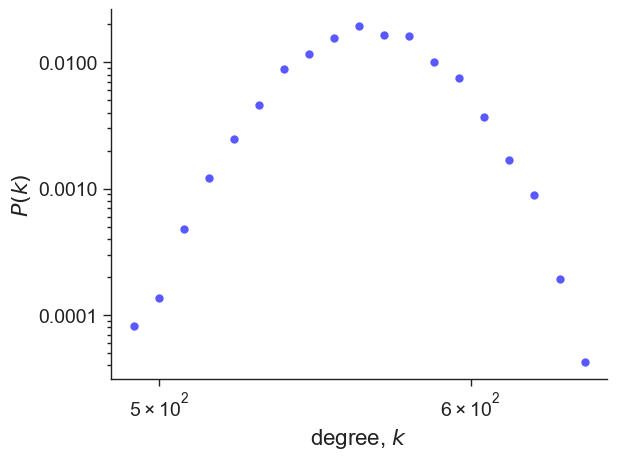

In [59]:
ax = plt.subplot(111)

plot_deg_dist(G_pp_graph, 20, "blue", False)
plt.legend(frameon=False, numpoints=1)
plt.xlabel(r"degree, $k$")
plt.ylabel(r"$P(k)$")
despine()

# Customize the tick formatter for the x and y axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))


plt.show()

Here are the mean and standard deviation for the path lengths and clustering coefficients

In [ ]:
mean_shortest_PPG = np.mean(short_path_PPG)
std_shortest_PPG = np.std(short_path_PPG)
print(f"Mean Shortest Path: {np.mean(short_path_PPG)}")
print(f"Standard Deviaton of the Shortest Path: {np.std(short_path_PPG)}")

mean_clustering_PPG = np.mean(clustering_PPG)
std_clustering_PPG = np.std(clustering_PPG)
print(f"Mean Clustering Coefficient: {np.mean(clustering_PPG)}")
print(f"Standard Deviaton of the Clustering Coefficient: {np.std(clustering_PPG)}")

Mean Shortest Path: 1.8877009012244177
Standard Deviaton of the Shortest Path: 0.00010836116213428748
Mean Clustering Coefficient: 0.11453719235070015
Standard Deviaton of the Clustering Coefficient: 0.00010508014603923277


Original Clustering:  0.5643044309447203


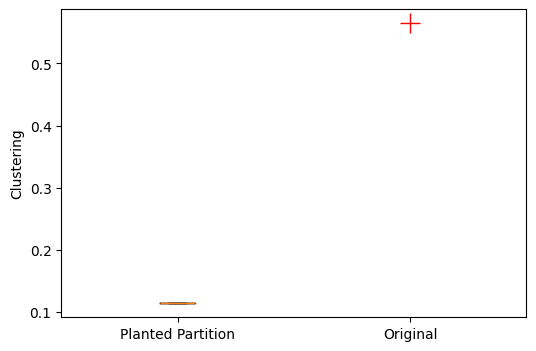

In [ ]:
fig = plt.figure(figsize=(6,4))

print("Original Clustering: ", C_mean_dev)

plt.boxplot(clustering_PPG)
plt.plot(2,C_mean_dev,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['Planted Partition','Original'])
plt.ylabel('Clustering')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

Original Shortest Path:  4.050134226653897


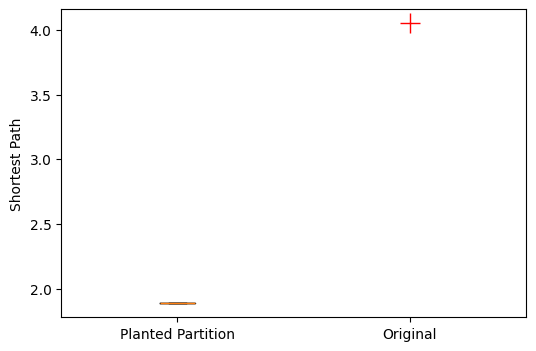

In [ ]:
fig = plt.figure(figsize=(6,4))

print("Original Shortest Path: ", S_Avg_Path)

plt.boxplot(short_path_PPG)
plt.plot(2,S_Avg_Path,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['Planted Partition','Original'])
plt.ylabel('Shortest Path')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

### Generate a Degree Preserving Null Model

In [ ]:
clustering_DP = []
short_path_DP = []

d_DP = 0

DP = G_nonDev.copy()

for i in tqdm(range(1000)): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=10*G_nonDev.number_of_edges(),max_tries=1000000)
    C_DP = np.mean(list(nx.clustering(DP).values()))
    if nx.is_connected(DP)==True:
        d_DP = nx.average_shortest_path_length(DP,weight=None)
    clustering_DP.append(C_DP)
    short_path_DP.append(d_DP)
    

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


In [ ]:
mean_shortest_DP = np.mean(short_path_DP)
std_shortest_DP = np.std(short_path_DP)
print(f"Mean Shortest Path: {np.mean(short_path_DP)}")
print(f"Standard Deviaton of the Shortest Path: {np.std(short_path_DP)}")

mean_clustering_DP = np.mean(clustering_DP)
std_clustering_DP = np.std(clustering_DP)
print(f"Mean Clustering Coefficient: {np.mean(clustering_DP)}")
print(f"Standard Deviaton of the Clustering Coefficient: {np.std(clustering_DP)}")

Mean Shortest Path: 0.0
Standard Deviaton of the Shortest Path: 0.0
Mean Clustering Coefficient: 0.007673852198834502
Standard Deviaton of the Clustering Coefficient: 0.0002971682584695155


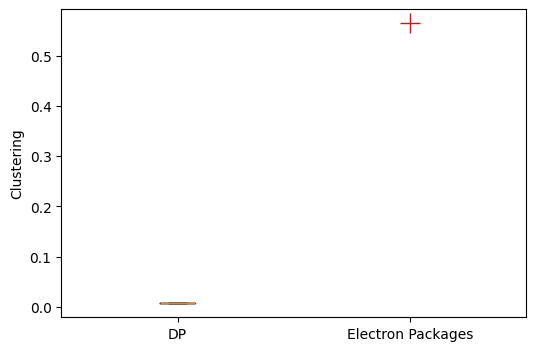

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(clustering_DP)
plt.plot(2,C_mean_dev,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['DP','Electron Packages'])
plt.ylabel('Clustering')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

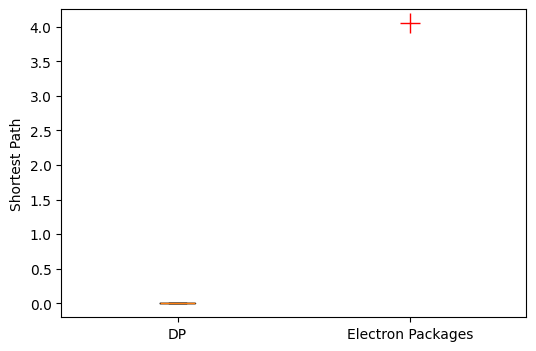

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(short_path_DP)
plt.plot(2,S_Avg_Path,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['DP','Electron Packages'])
plt.ylabel('Shortest Path')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

### Take the Top 5 Community Subgraph

Note I remembered and marked down the top 5 communities calculated in the graph  whe I assign the variable `top_5_communities`

In [ ]:
top_5_communities = ["10", "33", "6", "23", "18"]
with open('Used_in_Gephi/nonDevDepNodeListCommunityUnweightedEigen.csv', 'r') as file:
    for line in file:
        id, label, dependencies, communities, eigenval = line.strip().split('\t')

        deps = dependencies.split(",")
        deps = [x for x in deps if (']' and '[') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("]", '') for x in deps]
        G_nonDev.add_node(id, label=label, dependencies=deps, communities=communities, eigenval=eigenval)

G_nonDev_top5 = nx.Graph()

for n in G_nonDev.nodes():
    if G_nonDev.nodes[n]["communities"] in top_5_communities:
        G_nonDev_top5.add_node(n, label=n, dependencies=G_nonDev.nodes[n]["dependencies"], communities=G_nonDev.nodes[n]["communities"])


with open('Project_Data/nonDevDepEdgeList.csv', 'r') as file:
    next(file)

    for line in file:
        source, target, weight, label = line.strip().split('\t')

    
        deps = label.split(",")
        # deps = [x for x in deps if ('}' and '{') not in x]
        deps = [x.replace('"', '') for x in deps]
        deps = [x.replace("'", '') for x in deps]
        deps = [x.replace(" ", '') for x in deps]
        deps = [x.replace("}", '') for x in deps]
        deps = [x.replace("{", '') for x in deps]

        if G_nonDev_top5.has_node(source) and G_nonDev_top5.has_node(target):

            G_nonDev_top5.add_edge(source, target)

            # print(f'{source}, {target}, {weight}, {deps}')
            G_nonDev_top5[source][target]['weight'] = float(weight)
            G_nonDev_top5[source][target]['label'] = deps

### Repeat the setup for the Planted Partition Graph and the Degree Preserving Null Models

In [ ]:
C_mean_dev_subgraph = np.mean(list(nx.clustering(G_nonDev_top5).values()))

N_subgraph = len(G_nonDev)

# p value at which giant component (of size log(n) nodes) is expected
p_giant_nonDev_subgraph = 1.0 / (N_subgraph - 1)
# p value at which graph is expected to become completely connected
p_conn_nonDev_subgraph = math.log(N_subgraph) / N_subgraph

# identify largest connected component | link: https://networkx.org/documentation/stable/auto_examples/graphviz_layout/plot_giant_component.html
Rcc_nonDev_subgraph = sorted(nx.connected_components(G_nonDev_top5), key=len, reverse=True)
Giant_subgraph = G_nonDev.subgraph(Rcc_nonDev_subgraph[0])

S_Avg_Path_subgraph = nx.average_shortest_path_length(Giant_subgraph)

In [ ]:
# This works since Communities id's go from 1 to the last community
transform_ids = {10:0, 33:1, 6:2, 23:3, 18:4}

community_sets_subgraph = [set() for _ in range(5)]
for node in G_nonDev_top5.nodes():
    community_sets_subgraph[transform_ids[int(G_nonDev_top5.nodes[node]['communities'])]].add(node)


In [ ]:
edges_in_subgraph = [0] * len(community_sets_subgraph)
edges_out_subgraph = [0] * len(community_sets_subgraph)
all_edges_subgraph = [0] * len(community_sets_subgraph)
visited_in_subgraph = []

for i in range(len(community_sets_subgraph)):
    for n in community_sets_subgraph[i]:
        for e in G_nonDev_top5.neighbors(n):
            if e in visited_in_subgraph:
                pass
            if e in community_sets_subgraph[i]:
                edges_in_subgraph[i] += 1
            else:
                edges_out_subgraph[i] += 1
            all_edges_subgraph[i] += 1
        visited_in_subgraph.append(n)
    visited_in_subgraph = []

print(edges_in_subgraph)
print(edges_out_subgraph)
print(all_edges_subgraph)

[1378, 1366, 1468, 1322, 1176]
[228, 228, 285, 172, 253]
[1606, 1594, 1753, 1494, 1429]


In [ ]:
p_in_subgraph = 0
p_out_subgraph = 0

for i in range(len(community_sets_subgraph)):
    if all_edges_subgraph[i] != 0:
        p_in_subgraph += (edges_in_subgraph[i] / all_edges_subgraph[i])
        p_out_subgraph += (edges_out_subgraph[i] / all_edges_subgraph[i])

p_in_subgraph = p_in_subgraph / len(community_sets_subgraph)
p_out_subgraph = p_out_subgraph / len(community_sets_subgraph)

avg_vertices_subgraph = int(len(G_nonDev_top5.nodes) / len(community_sets_subgraph))

print(f'\% of Edges Within Community: {p_in_subgraph}\n\% of Edges Going Out of Community: {p_out_subgraph}')
print(f"Average Nodes in Community: {avg_vertices_subgraph}")

\% of Edges Within Community: 0.8520486987727155
\% of Edges Going Out of Community: 0.14795130122728445
Average Nodes in Community: 240


### Generate Null Models

##### Planted Partition Graphs

In [ ]:

short_path_PPG_subgraph = []
clustering_PPG_subgraph = []

for i in tqdm(range(10)):
    # Set the seed based on current time
    random.seed(int(time.time()))
    # Generate a random number
    random_number = round(((random.random()) * 100))

    G_pp_subgraph = nx.planted_partition_graph(l=len(community_sets_subgraph), k=avg_vertices_subgraph, p_in=p_in_subgraph, p_out=p_out_subgraph, seed=random_number)
    short_path_PPG_subgraph.append(nx.average_shortest_path_length(G_pp_subgraph))
    clustering_PPG_subgraph.append(np.mean(list(nx.clustering(G_pp_subgraph).values())))


In [ ]:
mean_shortest_PPG_subgraph = np.mean(short_path_PPG_subgraph)
std_shortest_PPG_subgraph = np.std(short_path_PPG_subgraph)
print(f"Mean Shortest Path: {np.mean(mean_shortest_PPG_subgraph)}")
print(f"Standard Deviaton of the Shortest Path: {np.std(std_shortest_PPG_subgraph)}")

mean_clustering_PPG_subgraph = np.mean(clustering_PPG_subgraph)
std_clustering_PPG_subgraph = np.std(clustering_PPG_subgraph)
print(f"Mean Clustering Coefficient: {np.mean(mean_clustering_PPG_subgraph)}")
print(f"Standard Deviaton of the Clustering Coefficient: {np.std(std_clustering_PPG_subgraph)}")

##### Degree Preserving Null Model

In [ ]:
clustering_DP_subgraph = []
short_path_DP_subgraph = []

d_DP_subgraph = 0

DP_subgraph = G_nonDev_top5.copy()

for i in tqdm(range(10)): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=10*G_nonDev_top5.number_of_edges(),max_tries=1000000)
    C_DP_subgraph = np.mean(list(nx.clustering(DP_subgraph).values()))
    if nx.is_connected(DP_subgraph)==True:
        d_DP_subgraph = nx.average_shortest_path_length(DP_subgraph,weight=None)
    clustering_DP_subgraph.append(C_DP_subgraph)
    short_path_DP_subgraph.append(d_DP_subgraph)
    

In [ ]:
mean_shortest_DP_subgraph = np.mean(short_path_DP_subgraph)
std_shortest_DP_subgraph = np.std(short_path_DP_subgraph)
print(f"Mean Shortest Path: {np.mean(mean_shortest_DP_subgraph)}")
print(f"Standard Deviaton of the Shortest Path: {np.std(std_shortest_DP_subgraph)}")

mean_clustering_DP_subgraph = np.mean(clustering_DP_subgraph)
std_clustering_DP_subgraph = np.std(clustering_DP_subgraph)
print(f"Mean Clustering Coefficient: {np.mean(mean_clustering_DP_subgraph)}")
print(f"Standard Deviaton of the Clustering Coefficient: {np.std(std_clustering_DP_subgraph)}")

##### Clustering Coefficient Box Plots

In [ ]:
fig = plt.figure(figsize=(6,4))

print("Original Clustering: ", C_mean_dev_subgraph)

plt.boxplot(clustering_PPG_subgraph)
plt.plot(2,C_mean_dev_subgraph,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['Planted Partition','Original'])
plt.ylabel('Clustering')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(clustering_DP_subgraph)
plt.plot(2,C_mean_dev_subgraph,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['DP','Electron Packages'])
plt.ylabel('Clustering')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

##### Shortest Paths Box Plots

In [ ]:
fig = plt.figure(figsize=(6,4))

print("Original Shortest Path: ", S_Avg_Path_subgraph)

plt.boxplot(short_path_PPG_subgraph)
plt.plot(2,S_Avg_Path_subgraph,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['Planted Partition','Original'])
plt.ylabel('Shortest Path')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(short_path_DP_subgraph)
plt.plot(2,S_Avg_Path_subgraph,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['DP','Electron Packages'])
plt.ylabel('Shortest Path')
plt.xlim([0.5,2.5])
plt.show()

# data different from erdos renyi